
## Dog Breed Classifier

---
In this notebook, you will make the first steps towards developing an algorithm that could be used as part of a mobile or web app. At the end of this project, your code will accept any user-supplied image as input. If a dog is detected in the image, it will provide an estimate of the dog's breed. If a human is detected, it will provide an estimate of the dog breed that is most resembling. 

### Import Dog Dataset


In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('/data/dog_images/train')
valid_files, valid_targets = load_dataset('/data/dog_images/valid')
test_files, test_targets = load_dataset('/data/dog_images/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("/data/dog_images/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset



In [2]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("/data/lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans



Number of faces detected: 1


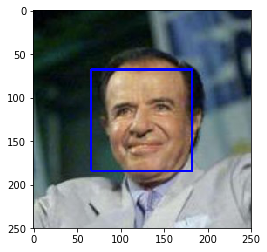

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[2])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector


In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

### (IMPLEMENTATION) Assess the Human Face Detector

__Question 1:__ Use the code cell below to test the performance of the `face_detector` function.  
- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  You will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.

__Answer:__ 100% of the first 100 images in the human dataset is detected as humans. However 11% of images of the first 100 images in the dog dataset is detected as humans.

In [5]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]
# Do NOT modify the code above this line.

## TODO: Test the performance of the face_detector algorithm 
## on the images in human_files_short and dog_files_short.
dog_humandetector=[]
for image in dog_files_short:
    if face_detector(image)==True:
        dog_humandetector.append(1)
    else:
        dog_humandetector.append(0)

human_humandetector=[]
for image in human_files_short:
    if face_detector(image)==True:
        human_humandetector.append(1)
    else:
        human_humandetector.append(0)
        
print('%d percent of the first 100 images of human_files have a detected human face.' % sum(human_humandetector))
print('%d percent of the first 100 images of dog_files have a detected human face.' % sum(dog_humandetector))

100 percent of the first 100 images of human_files have a detected human face.
11 percent of the first 100 images of dog_files have a detected human face.


__Question 2:__ This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). In your opinion, is this a reasonable expectation to pose on the user? If not, can you think of a way to detect humans in images that does not necessitate an image with a clearly presented face?

__Answer:__The user expects to get an output that identifies a face when they input a human image. The algorithm needs to be impoved if it misidentifies a human face. It can be impoved by augmenting the images and then inputting them into the face_detector algorithm.


---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [7]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

102858752/102853048 [==============================] - 2s 0us/step


### Pre-process the Data

In [8]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50



In [9]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector


In [10]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### (IMPLEMENTATION) Assess the Dog Detector

__Question 3:__ Use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?

__Answer:__ 0% of the first 100 images of human_files have a detected dog and 100% of the first 100 images in dog_files have a detected dog.

In [11]:
### TODO: Test the performance of the dog_detector function

human_dogdetector=[]
for images in human_files_short:
    if dog_detector(images)==True:
        human_dogdetector.append(1)
    else:
        human_dogdetector.append(0)

dog_dogdetector=[]
for images in dog_files_short:
    if dog_detector(images)==True:
        dog_dogdetector.append(1)
    else:
        dog_dogdetector.append(0)

        
        
print('%d percent of the first 100 images of human_files have detected a dog.' % sum(human_dogdetector))
print('%d percent of the first 100 images of dog_files have detected a dog.' % sum(dog_dogdetector))

0 percent of the first 100 images of human_files have detected a dog.
100 percent of the first 100 images of dog_files have detected a dog.


---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, you will create a CNN that classifies dog breeds.  You must create your CNN _from scratch_ (so, you can't use transfer learning _yet_!), and you must attain a test accuracy of at least 1%.  In Step 5 of this notebook, you will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

Be careful with adding too many trainable layers!  More parameters means longer training, which means you are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; you can extrapolate this estimate to figure out how long it will take for your algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Your vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  

Remember that the practice is far ahead of the theory in deep learning.  Experiment with many different architectures, and trust your intuition.  And, of course, have fun! 

### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [12]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|██████████| 836/836 [00:09<00:00, 109.21it/s]


### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        model.summary()

We have imported some Python modules to get you started, but feel free to import as many modules as you need.  If you end up getting stuck, here's a hint that specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
           
__Question 4:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  If you chose to use the hinted architecture above, describe why you think that CNN architecture should work well for the image classification task.

__Answer:__ After initialising the model for training, a convolutional layer was added. This layer has 16 filters with a 2x2 window. The 'relu' activation function is used that returns if the value is positive and 0 for all negative values. The padding is set to 'same' to avoid losing any data. After the first Convolutional Layer, a Max Pool layer is added to reduce the dimensionality of the Convolutional Layer. Then a dropout function is added with a probabilty of 30%. This will likely prevent overfitting. Another convolutional layer is added with an increased number of filters. This will increase the depth of the model and detect more patterns in the image. After that a Max Pool Layer is added to reduce the dimensionalty more. Batch normalization is introduced so our model converges faster and we dont have to worry about the scale of our input features.A third convolutional layer is added with more number of filters followed by a second dropout layer. A Global Pool Layer is added to further decrease dimensionality. This is followed by a dense layer with output nodes the same number as the number of categories of dogs there are in the dataset. The final layer has a softmax activation function because of its probabibity distribution characteristics.

In [13]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense, BatchNormalization
from keras.models import Sequential

model = Sequential()
model.add(Conv2D(16, (2,2), padding="same", input_shape=(224,224,3),activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.3))
model.add(Conv2D(32, (2,2), padding="same",activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(BatchNormalization())
model.add(Conv2D(64, (2,2), padding="same",activation='relu'))
model.add(Dropout(0.3))
model.add(GlobalAveragePooling2D())
model.add(Dense(133,activation='softmax'))

### TODO: Define your architecture.

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 16)      208       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 112, 112, 16)      0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 112, 112, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 32)      2080      
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 56, 56, 32)        128       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 64)        8256      
__________

### Compile the Model

In [14]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [15]:
from keras.callbacks import ModelCheckpoint  

### TODO: specify the number of epochs that you would like to use to train the model.

epochs = 10

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/10
6680/6680 [==============================] - 26s 4ms/step - loss: 4.8842 - acc: 0.0076 - val_loss: 4.8779 - val_acc: 0.0108
Epoch 2/10
6680/6680 [==============================] - 25s 4ms/step - loss: 4.8270 - acc: 0.0165 - val_loss: 4.8372 - val_acc: 0.0120
Epoch 3/10
6680/6680 [==============================] - 25s 4ms/step - loss: 4.7594 - acc: 0.0217 - val_loss: 4.7963 - val_acc: 0.0192
Epoch 4/10
6680/6680 [==============================] - 25s 4ms/step - loss: 4.7011 - acc: 0.0295 - val_loss: 4.8434 - val_acc: 0.0180
Epoch 5/10
6680/6680 [==============================] - 25s 4ms/step - loss: 4.6445 - acc: 0.0329 - val_loss: 4.8544 - val_acc: 0.0240
Epoch 6/10
6680/6680 [==============================] - 25s 4ms/step - loss: 4.5911 - acc: 0.0374 - val_loss: 4.7300 - val_acc: 0.0228
Epoch 7/10
6680/6680 [==============================] - 25s 4ms/step - loss: 4.5452 - acc: 0.0425 - val_loss: 4.7150 - val_acc: 0.0228
Epoch 8/

### Load the Model with the Best Validation Loss

In [16]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [17]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 2.7512%


---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, you will get a chance to use transfer learning to train your own CNN.

### Obtain Bottleneck Features

In [18]:
bottleneck_features = np.load('/data/bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [19]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 133)               68229     
Total params: 68,229
Trainable params: 68,229
Non-trainable params: 0
_________________________________________________________________


### Compile the Model

In [20]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [21]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 2s 314us/step - loss: 12.5474 - acc: 0.1150 - val_loss: 11.0167 - val_acc: 0.1964
Epoch 2/20
6680/6680 [==============================] - 2s 260us/step - loss: 10.4954 - acc: 0.2654 - val_loss: 10.3856 - val_acc: 0.2539
Epoch 3/20
6680/6680 [==============================] - 2s 257us/step - loss: 9.9772 - acc: 0.3213 - val_loss: 10.1334 - val_acc: 0.2958
Epoch 4/20
6680/6680 [==============================] - 2s 258us/step - loss: 9.7507 - acc: 0.3490 - val_loss: 10.0961 - val_acc: 0.2982
Epoch 5/20
6680/6680 [==============================] - 2s 255us/step - loss: 9.6226 - acc: 0.3686 - val_loss: 9.9514 - val_acc: 0.3257
Epoch 6/20
6680/6680 [==============================] - 2s 258us/step - loss: 9.4950 - acc: 0.3814 - val_loss: 9.8702 - val_acc: 0.3269
Epoch 7/20
6680/6680 [==============================] - 2s 259us/step - loss: 9.4331 - acc: 0.3937 - val_loss: 9.8616 - val_acc: 0.

### Load the Model with the Best Validation Loss

In [22]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [23]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 43.7799%


### Predict Dog Breed with the Model

In [24]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)



In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras.  These are already in the workspace, at /data/bottleneck_features.  If you wish to download them on a different machine, they can be found at:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features




### (IMPLEMENTATION) Obtain Bottleneck Features



In [25]:
### TODO: Obtain bottleneck features from another pre-trained CNN.
bottleneck_features = np.load('/data/bottleneck_features/DogResnet50Data.npz')
train_Resnet50 = bottleneck_features['train']
valid_Resnet50 = bottleneck_features['valid']
test_Resnet50 = bottleneck_features['test']

### (IMPLEMENTATION) Model Architecture

Create a CNN to classify dog breed.  At the end of your code cell block, summarize the layers of your model by executing the line:
    
        <your model's name>.summary()
   
__Question 5:__ Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  Describe why you think the architecture is suitable for the current problem.

__Answer:__ The Resnet50 architecture was chosen because of the complexity of our data. As seen from the previous models trained with the dog images, the model without transfer learning has an accuracy of 4.5455% and with the VGG16 architecture it got an accuracy of 42.9426%. As we go deeper into the model, our accuracy gets saturated and then degrades rapidly. The Resnet model converges faster than other architectures provided and the issue with degrading accuracy is resolved. After the Resnet model, there are only two layers added. The Global Pooling layer to reduce dimensionality and the dense layer with the same number of nodes as the categories of dogs in our image dataset.



In [26]:
### TODO: Define your architecture.
Resnet50_model = Sequential()
Resnet50_model.add(GlobalAveragePooling2D(input_shape=train_Resnet50.shape[1:]))
Resnet50_model.add(Dense(133, activation='softmax'))

Resnet50_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_3 ( (None, 2048)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


### (IMPLEMENTATION) Compile the Model

In [27]:
### TODO: Compile the model.
Resnet50_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### (IMPLEMENTATION) Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [28]:
### TODO: Train the model.
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Resnet50.hdf5', 
                               verbose=1, save_best_only=True)

Resnet50_model.fit(train_Resnet50, train_targets, 
          validation_data=(valid_Resnet50, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 2s 282us/step - loss: 1.6287 - acc: 0.6004 - val_loss: 0.8175 - val_acc: 0.7473
Epoch 2/20
6680/6680 [==============================] - 2s 230us/step - loss: 0.4395 - acc: 0.8639 - val_loss: 0.7025 - val_acc: 0.7964
Epoch 3/20
6680/6680 [==============================] - 2s 228us/step - loss: 0.2575 - acc: 0.9189 - val_loss: 0.6439 - val_acc: 0.7952
Epoch 4/20
6680/6680 [==============================] - 2s 227us/step - loss: 0.1757 - acc: 0.9436 - val_loss: 0.6531 - val_acc: 0.8132
Epoch 5/20
6680/6680 [==============================] - 2s 227us/step - loss: 0.1229 - acc: 0.9611 - val_loss: 0.6817 - val_acc: 0.8251
Epoch 6/20
6680/6680 [==============================] - 2s 228us/step - loss: 0.0871 - acc: 0.9746 - val_loss: 0.6574 - val_acc: 0.8204
Epoch 7/20
6680/6680 [==============================] - 2s 226us/step - loss: 0.0647 - acc: 0.9801 - val_loss: 0.7285 - val_acc: 0.8144
E

### (IMPLEMENTATION) Load the Model with the Best Validation Loss

In [29]:
Resnet50_model.load_weights('saved_models/weights.best.Resnet50.hdf5')

### (IMPLEMENTATION) Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [30]:
Resnet50_predictions = [np.argmax(Resnet50_model.predict(np.expand_dims(feature, axis=0))) for feature in test_Resnet50]

test_accuracy = 100*np.sum(np.array(Resnet50_predictions)==np.argmax(test_targets, axis=1))/len(Resnet50_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 79.9043%


### (IMPLEMENTATION) Predict Dog Breed with the Model


In [31]:
def Resnet50_predict_breed(img_path):
    
    bottleneck_features=extract_Resnet50(path_to_tensor(img_path))
    
    predicted_breed=Resnet50_model.predict(bottleneck_features)

    dog_name=dog_names[np.argmax(predicted_breed)]
    
    print(dog_name)
    

---
<a id='step6'></a>
## Step 6: Write your Algorithm

Write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

You are welcome to write your own functions for detecting humans and dogs in images, but feel free to use the `face_detector` and `dog_detector` functions developed above.  You are __required__ to use your CNN from Step 5 to predict dog breed.  

Some sample output for our algorithm is provided below, but feel free to design your own user experience!

![Sample Human Output](images/sample_human_output.png)


### (IMPLEMENTATION) Write your Algorithm

In [32]:
import matplotlib.image as mpimg

def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

def Resnet50_predict_breed(img_path):
    bottleneck_features=extract_Resnet50(path_to_tensor(img_path))
    predicted_breed=Resnet50_model.predict(bottleneck_features)
    return dog_names[np.argmax(predicted_breed)]
   
    
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0


def human_dog_detector(img_path):
    img=mpimg.imread(img_path)
    imgplot = plt.imshow(img)
    plt.show()
    
    if face_detector(img_path)==True:
        x=Resnet50_predict_breed(img_path)
        print("Hello!Turns out you look like a {}.".format(x))    
    elif dog_detector(img_path)==True:
        x=Resnet50_predict_breed(img_path)
        print("This is a {}.The best of the best.".format(x))    
    else:
        print("There seems to be an error. The input image is neither a dog or human.")
    
    

---
<a id='step7'></a>
## Step 7: Test Your Algorithm

In this section, you will take your new algorithm for a spin!  What kind of dog does the algorithm think that __you__ look like?  If you have a dog, does it predict your dog's breed accurately?  If you have a cat, does it mistakenly think that your cat is a dog?

### (IMPLEMENTATION) Test Your Algorithm on Sample Images!

Test your algorithm at least six images on your computer.  Feel free to use any images you like.  Use at least two human and two dog images.  

__Question 6:__ Is the output better than you expected :) ?  Or worse :( ?  Provide at least three possible points of improvement for your algorithm.

__Answer:__ The output from the images is as expected, the accuracy of our model is 80%. The first image of the dog that is inputted into the model has an output of the breed being Akita. While searching for images this image was taken from the category Husky. Because Husky's and Akita's look very similar our model might have not been able to identify the distinction that seperates them. The second image of the dog is correclty identified as a Labrador. There are three images of a human. The first one is correctly identifed. The second and third were inputted because they do not show the face of the humans clearly. The first soccer image was misclassified as an error, but the secon one was correclty classified by the human detector. But it only identified two faces on the image and not three. Also for this image the dog breed was classifed but for which face remain unknown. The last two images that are neither dog or human and are correclty classifed. Few ways to improve the algorith can be, 1-Augment our images so our model can identify more pattern. 2-Use Batch Normalization for the hidden layers to improve variance in data and make our model conerge faster. 3-Increase the number of layers in our model so it understands the data better.

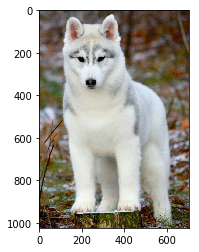

94658560/94653016 [==============================] - 1s 0us/step
This is a in/005.Alaskan_malamute.The best of the best.


In [33]:
human_dog_detector('dog.jpg')

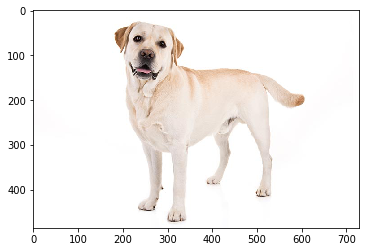

This is a in/096.Labrador_retriever.The best of the best.


In [34]:
human_dog_detector('Labrador-Retriever-On-White-01.jpg')

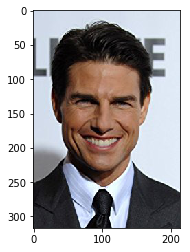

Hello!Turns out you look like a in/032.Boston_terrier.


In [35]:
human_dog_detector('tomcruise.jpg')

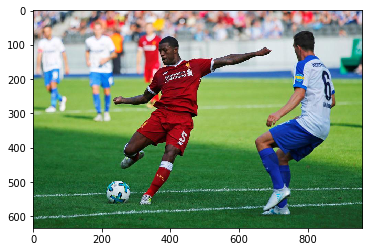

There seems to be an error. The input image is neither a dog or human.


In [36]:
human_dog_detector('football(person).jpg')

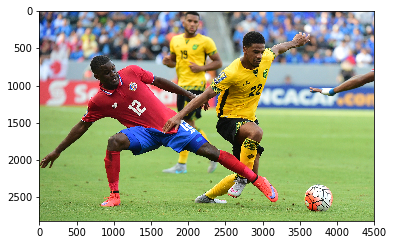

Hello!Turns out you look like a in/112.Nova_scotia_duck_tolling_retriever.


In [37]:
human_dog_detector('footbal.2.jpg')

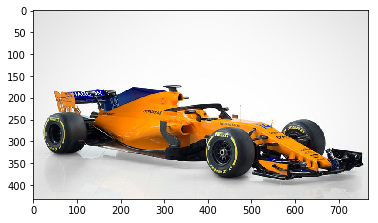

There seems to be an error. The input image is neither a dog or human.


In [38]:
human_dog_detector('skysports-f1-mcl33-mclaren_4238483.jpg')

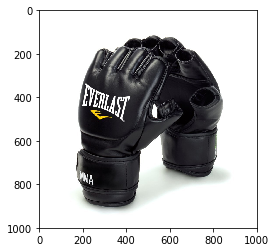

There seems to be an error. The input image is neither a dog or human.


In [39]:
human_dog_detector('61UoumGaPpL._SL1000_.jpg')